# Prepare Interim Data

This code runs the interim data through the pipeline arrived at via the previous EDA and implemented in the cleaning.py module.

In [1]:
import pandas as pd
from cleaning import prepare, remove_punctuation, remove_numbers, tokenize, remove_stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aabel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle('../data/interim/drugs.pkl') # load interim data

In [3]:
df.head()

,target,text
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...
4,TOPICAL,"Directions wet face, apply to hand, massage fa..."


In [4]:
# run text through pipeline 
pipeline = [str.lower, remove_punctuation, remove_numbers, tokenize, remove_stopwords]
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df['tokens_str'] = df['tokens'].apply(lambda x: ' '.join(x)) # also save tokens as string
df.head()

,target,text,tokens,tokens_str
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[adults, take, pellets, mouth, three, times, d...",adults take pellets mouth three times daily su...
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[adults, dissolve, tongue, three, times, day, ...",adults dissolve tongue three times day directe...
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...,"[recommended, regimen, treatment, bacterial, c...",recommended regimen treatment bacterial conjun...
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[use, lowest, effective, shortest, duration, c...",use lowest effective shortest duration consist...
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[wet, face, apply, hand, massage, face, gently...",wet face apply hand massage face gently rinse ...


In [5]:
pd.to_pickle(df, '../data/processed/drugs.pkl') # save as file to data/processed

# Descriptive Statistics

In [6]:
print("The dataset has {0} rows and {1} columns.".format(df.shape[0], df.shape[1]))

The dataset has 85328 rows and 4 columns.


## Target

In [7]:
df['target'].nunique()

57

57 classes is unwieldy. Let's look at their cumulative distribution to see if we can limit the number of classes without losing too much information.

In [8]:
df['target'].value_counts(normalize=True).cumsum().head()

ORAL             0.546456
TOPICAL          0.872527
INTRAVENOUS      0.906010
DENTAL           0.922429
INTRAMUSCULAR    0.938578
Name: target, dtype: float64

The top 5 classes account for over 93% of the data. We can bucket the rest into an OTHER class. 

In [9]:
top5_classes = df['target'].value_counts().head().index

In [10]:
top5_classes = df['target'].value_counts().head().index
df['target'] = df['target'].apply(lambda x: x if x in top5_classes else 'OTHER')

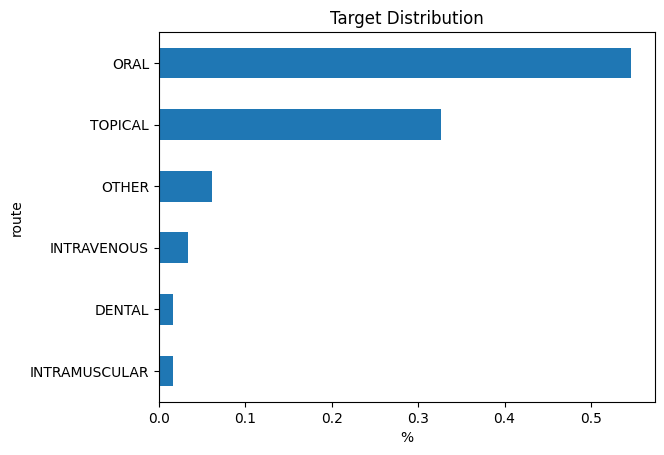

In [11]:
df['target'].value_counts(normalize=True).sort_values().plot(kind='barh')
plt.title('Target Distribution')
plt.ylabel('route')
plt.xlabel('%')
plt.show()

The target distribution is quite skewed. Over half of drugs are ORAL and about one third are TOPICAL. We should be mindful of this class imbalance when training and evaluating the classifier. 

## Text

In [12]:
df['token_count'] = df['tokens'].apply(len)

In [13]:
df['token_count'].describe()

count    85328.000000
mean       163.280412
std        277.040760
min          0.000000
25%         18.000000
50%         41.000000
75%        194.000000
max       5101.000000
Name: token_count, dtype: float64

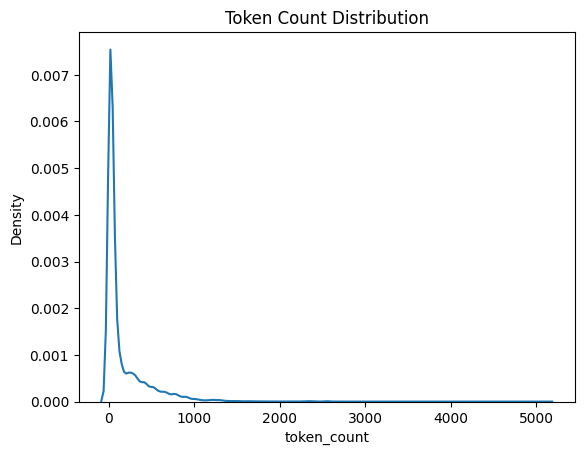

In [14]:
sns.kdeplot(df['token_count'])
plt.title('Token Count Distribution')
plt.show()

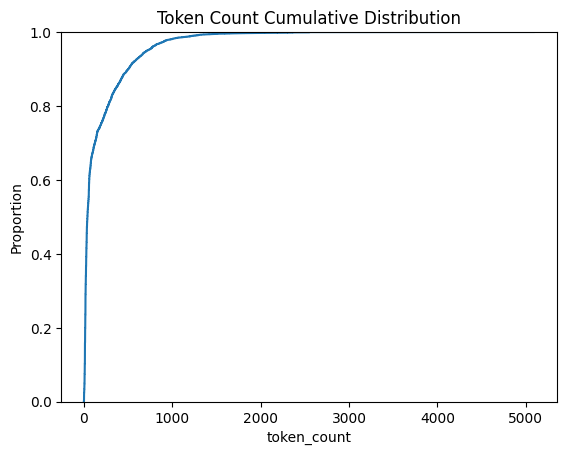

In [15]:
sns.ecdfplot(df['token_count'])
plt.title('Token Count Cumulative Distribution')
plt.show()

The token count distribution is very right-skewed. Almost 100% of dosage and administration labels have fewer than 1,000 tokens; however, some labels have more than 5x that. 

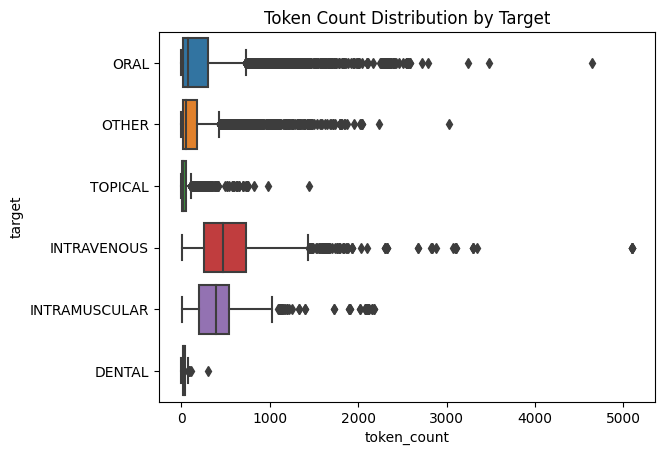

In [16]:
sns.boxplot(
    data=df,
    x='token_count',
    y='target'
)
plt.title('Token Count Distribution by Target')
plt.show()

TOPICAL and DENTAL dosage and administration labels tend to be shorter, while INTRAVENOUS and INTRAMUSCULAR tend to be longer. This makes sense because injections require more complex instructions than lotions/creams or toothpastes. 

In [17]:
all_tokens = []
df['tokens'].apply(lambda x: all_tokens.extend(x))
token_counts = Counter(all_tokens)

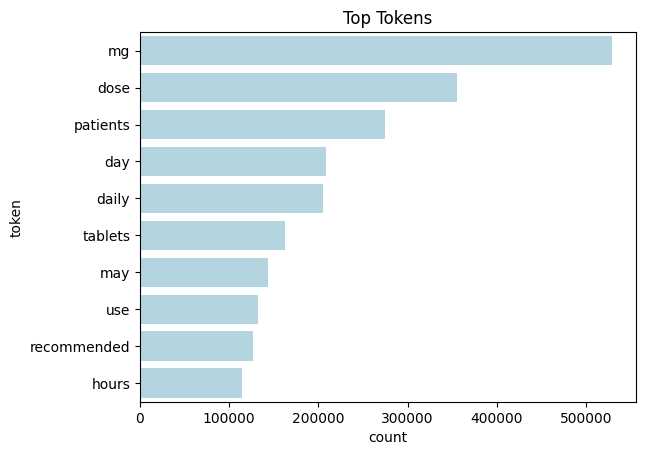

In [18]:
top_tokens = pd.DataFrame(token_counts.most_common(10), columns=['token', 'count'])
sns.barplot(
    data=top_tokens,
    x='count',
    y='token',
    color='lightblue'
)
plt.title('Top Tokens')
plt.show()

Let's see how the top tokens vary by route. 

In [19]:
def plot_top_tokens(route, n_tokens=10):
    route_df = df.query("target == @route")
    all_tokens = []
    route_df['tokens'].apply(lambda x: all_tokens.extend(x))
    token_counts = Counter(all_tokens)
    top_tokens = pd.DataFrame(token_counts.most_common(n_tokens), columns=['token', 'count'])
    sns.barplot(
        data=top_tokens,
        x='count',
        y='token',
        color='lightblue'
    )
    plt.title('Top Tokens - ' + route)
    plt.show()

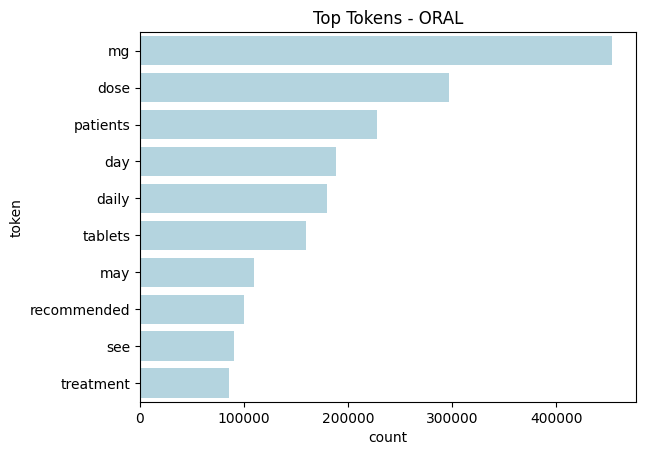

In [20]:
plot_top_tokens('ORAL')

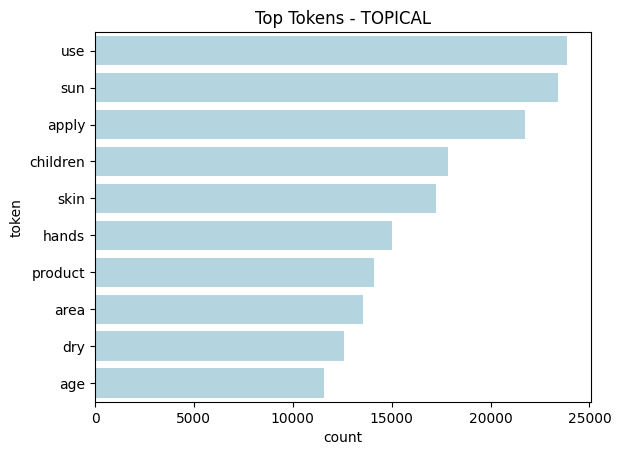

In [21]:
plot_top_tokens('TOPICAL')

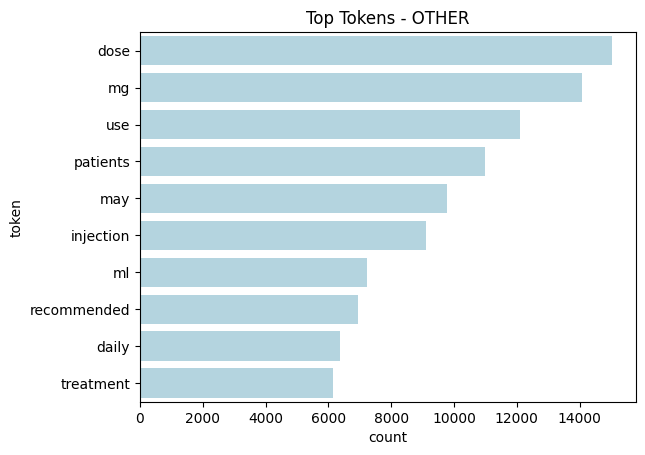

In [22]:
plot_top_tokens('OTHER')   

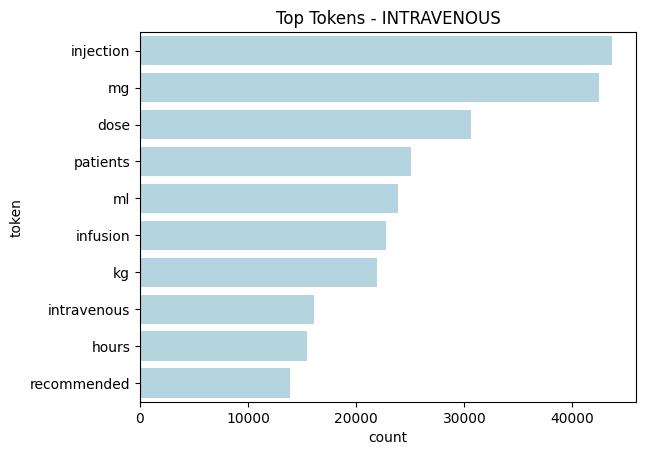

In [23]:
plot_top_tokens('INTRAVENOUS')

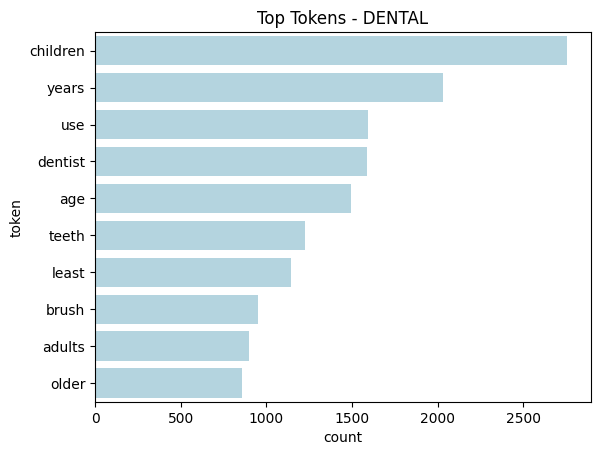

In [24]:
plot_top_tokens('DENTAL')

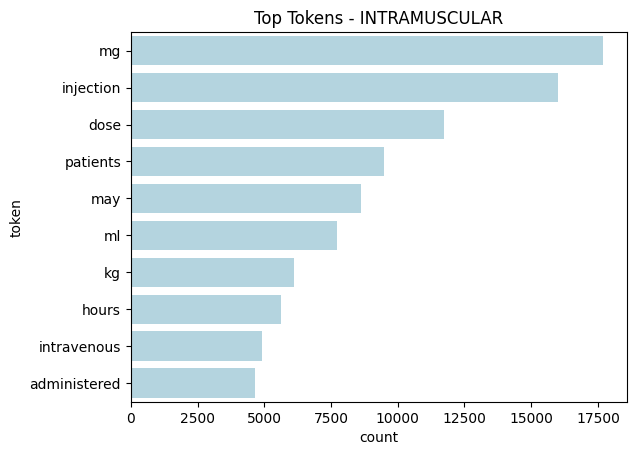

In [25]:
plot_top_tokens('INTRAMUSCULAR')

ORAL's top tokens are almost identical to the overall top tokens because it is the majority class. TOPICAL's top tokens are very distinct, so the classifier should have an easy time identifying topical instructions. OTHER has quite the mix of top tokens, which makes sense because it contains a mix of routes. This will be a challenge for the classifier. There's quite a lot of overlap between INTRAVENOUS and INTRAMUSCULAR, so it could be difficult for the classifier to distinguish them. DENTAL, like TOPICAL, has a pretty distinct set of top tokens so should be easy to classify. 